# Pet-проект: SQL-анализ лайков во ВКонтакте

## Задача

Проанализировать, что сильнее влияет на количество лайков под постами ВКонтакте:  
- время суток публикации  
- день недели  
- интервал между постами

Для анализа выбрана публичная страница философа и общественного деятеля [Александра Дугина](https://vk.com/duginag).

## Парсинг данных и первичный анализ

Импортируем необходимые библиотеки

In [32]:
!pip install -q duckdb

import requests
import pandas as pd
import duckdb

from matplotlib import pyplot as plt
import seaborn as sns

### Парсинг данных через requests и создание DataFrame

Используем requests для отправки API-запроса и получения данных для парсинга

In [33]:
# задаем параметры
domain = 'duginag'
token = 'YOUR_ACCESS_TOKEN_HERE'
v = 5.199
count = 100

# собираем их вместе
params = {'access_token': token,
          'v': v,
          'domain': domain,
          'count': count}

url = 'https://api.vk.com/method/wall.get'

In [34]:
# пишем запрос и передаем параметры
response = requests.get(url, params=params)

# преобразуем в JSON-формат
data = response.json()

# получаем список постов
posts = data['response']['items']

In [35]:
# извлекаем даты и лайки о каждом посте и формируем из них новый набор
rows = []
for post in posts:
    post_date = post['date']
    likes = post['likes']['count']
    rows.append({'date': post_date, 'likes': likes})

# преобразовываем список словарей в DataFrame 
df = pd.DataFrame(rows)

# сохраняем DataFrame в csv
df.to_csv('vk_posts.csv', index=False)

# создаем копию, чтобы не изменять исходные данные
df = df.copy()

Создадим столбец date_time посредством библиотеки Pandas.

In [36]:
df['date_time'] = pd.to_datetime(df['date'], unit='s')

# посмотрим на результат преобразования
df

,date,likes,date_time
0,1754571561,5,2025-08-07 12:59:21
1,1754569271,10,2025-08-07 12:21:11
2,1754569064,19,2025-08-07 12:17:44
3,1754557913,17,2025-08-07 09:11:53
4,1754557867,15,2025-08-07 09:11:07
...,...,...,...
95,1753807949,118,2025-07-29 16:52:29
96,1753807932,43,2025-07-29 16:52:12
97,1753807916,22,2025-07-29 16:51:56
98,1753807911,157,2025-07-29 16:51:51


### Первичный анализ данных путем визуализации

Построим линейный график и посмотрим на распределение лайков во времени.

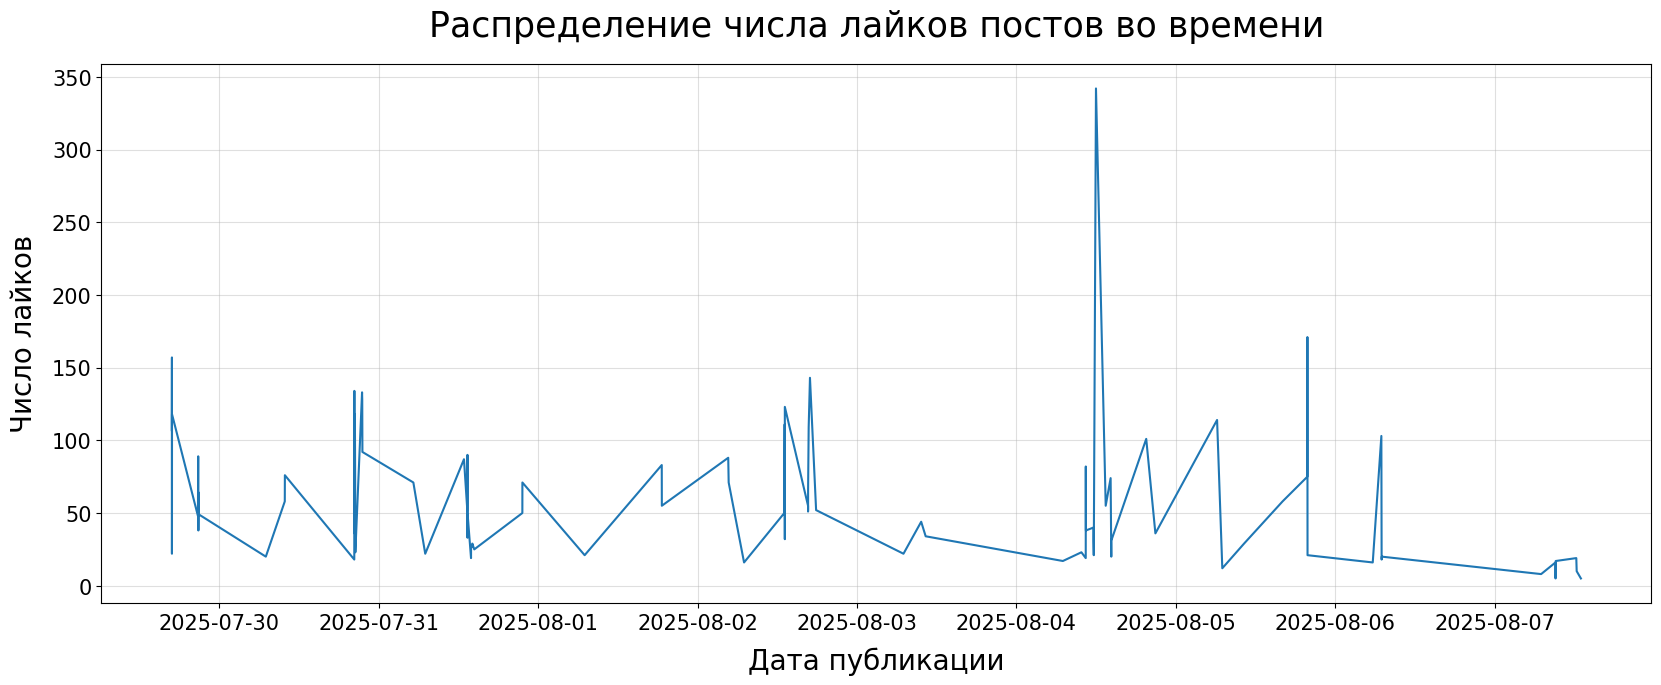

In [37]:
fig, ax = plt.subplots(figsize=(20, 7))

sns.lineplot(x='date_time', y='likes', data=df, ax=ax);

plt.grid(True, alpha=0.4)
plt.xlabel('Дата публикации', labelpad=10, fontsize=20)
plt.ylabel('Число лайков', labelpad=10, fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Распределение числа лайков постов во времени', pad=20, fontsize=25);

Обнаружено пиковое (аномальное) значение около 300 лайков, когда в среднем показатели не превышают 150. Очевидно, что это выброс, вызванный внешним фактором (например, медийным поводом), учитывать его в анализе будет некорректно. Избавимся от него.

In [38]:
#заменим все выдающиеся значения медианой (устойчива к выбросам)
df.loc[df['likes'] > 150, 'likes'] = df['likes'].median()

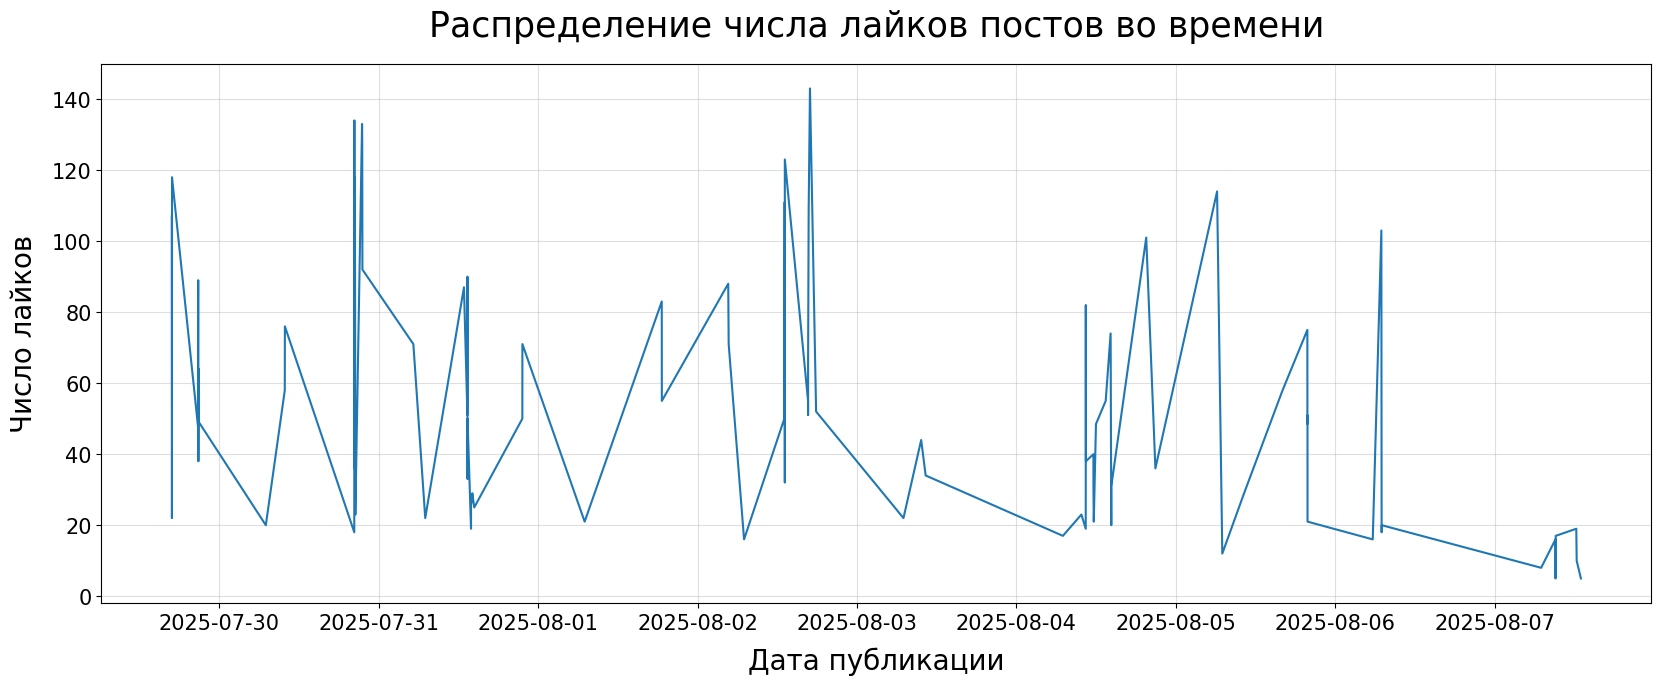

In [39]:
fig, ax = plt.subplots(figsize=(20, 7))

sns.lineplot(x='date_time', y='likes', data=df, ax=ax);

plt.grid(True, alpha=0.4)
plt.xlabel('Дата публикации', labelpad=10, fontsize=20)
plt.ylabel('Число лайков', labelpad=10, fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Распределение числа лайков постов во времени', pad=20, fontsize=25);

Данные приведены к корректному виду.

## Исследовательский анализ данных

### Влияние времени суток публикации на количество лайков

Формируем первый SQL запрос.

In [40]:
# создаем подключение
con = duckdb.connect(database=':memory:')

# регистрируем датафрейм в DuckDB под именем posts
con.register('posts', df)

# пишем запрос
query = """
WITH
sum_day AS (WITH
    t_d AS (SELECT *,
                   (CASE
                        WHEN EXTRACT(HOUR FROM date_time) BETWEEN 0 AND 5 THEN 'ночь'
                        WHEN EXTRACT(HOUR FROM date_time) BETWEEN 6 AND 11 THEN 'утро'
                        WHEN EXTRACT(HOUR FROM date_time) BETWEEN 12 AND 17 THEN 'день'
                   ELSE 'вечер'
                   END) AS time_day -- создаем категории времени суток
            FROM posts)
    SELECT SUM(likes) AS likes, -- считаем сумму для каждой категории
           time_day,
           COUNT(date) AS post_count, -- считаем количество наблюдений в каждой категории 
           SUM(likes) / COUNT(date) AS weighted_likes -- усредняем число лайков в каждой категории, чтобы уравновесить времена
    FROM t_d                                          -- когда было опубликовано мало записей
    GROUP BY time_day
    ORDER BY SUM(likes))
SELECT *,
       (weighted_likes / SUM(weighted_likes) OVER () * 100) AS procent -- считаем процент, который составляет взвешенное число лайков каждой категории
FROM sum_day                                                           -- от взвешенной суммы лайков среди всех категорий 
"""

# выполняем запрос и возвращаем результат в датафрейм
likes_time_day = con.execute(query).fetchdf()

# сортируем данные для последующей визуализации
likes_time_day = likes_time_day.sort_values(by='procent', ascending=False)

# посмотрим на результат
likes_time_day

,likes,time_day,post_count,weighted_likes,procent
2,1869.5,вечер,29,64.465517,29.861949
0,246.0,ночь,4,61.500000,28.488252
3,1957.5,день,35,55.928571,25.907434
1,1087.5,утро,32,33.984375,15.742365


#### Визуализируем распределение зависимости числа лайков от времени суток

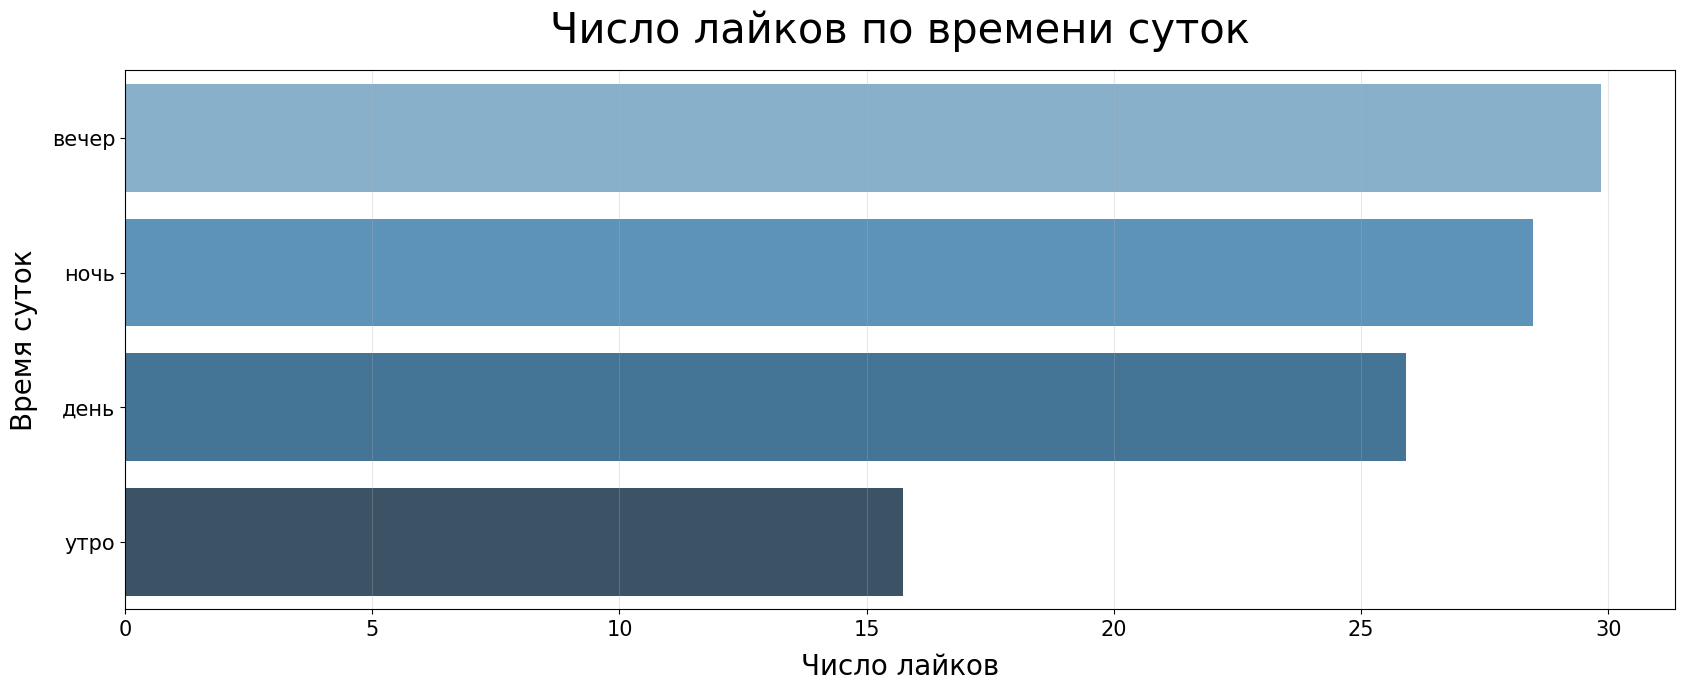

In [41]:
fig, ax = plt.subplots(figsize=(20, 7))

sns.barplot(x='procent', y='time_day', data=likes_time_day, ax=ax, palette='Blues_d')

plt.grid(axis='x', alpha=0.3)
plt.xlabel('Число лайков', labelpad=10, fontsize=20)
plt.ylabel('Время суток', labelpad=10, fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Число лайков по времени суток', pad=20, fontsize=30);

**Вывод**: замечено влияние времени суток на число лайков:
- наиболее число лайков у постов опубликованных вечером - почти 30%
- наменьшее - утром - с существенным отставанием от всех других категорий - всего 15%
- день и ночь показывают сопоставимые результаты 28% и 26% соответственно

### Влияние дня недели публикации на количество лайков

Формируем второй SQL запрос.

In [42]:
# пишем второй запрос
query2 = """
WITH
p_c_d AS (WITH
          d_n AS (SELECT *,
                         EXTRACT(ISODOW FROM date_time) AS day_n -- создаем категории дней недели
                  FROM posts)
          SELECT COUNT(date) AS post_count, -- считаем количество наблюдений в каждой категории
                 SUM(likes) AS likes, -- считаем сумму для каждой категории
                 SUM(likes) / COUNT(date) AS weighted_likes, -- считаем взвешенное число лайков в каждой категории
                 day_n                                       -- с учетом веса категории
          FROM d_n
          GROUP BY day_n)
SELECT *,
       CASE day_n
            WHEN 1 THEN 'Понедельник'
            WHEN 2 THEN 'Вторник'
            WHEN 3 THEN 'Среда'
            WHEN 4 THEN 'Четверг'
            WHEN 5 THEN 'Пятница'
            WHEN 6 THEN 'Суббота'
            WHEN 7 THEN 'Воскресенье'
       END AS day_name,
       (weighted_likes / (SUM(weighted_likes) OVER ()) * 100) AS procent -- считаем процент взвешенного число лайков от общей взвешенной суммы
FROM p_c_d
ORDER BY day_n
"""

# сохраняем результат в датафрейм
likes_day_number = con.execute(query2).fetchdf()
likes_day_number

,post_count,likes,weighted_likes,day_n,day_name,procent
0,15,636.5,42.433333,1,Понедельник,12.056946
1,19,1087.0,57.210526,2,Вторник,16.255717
2,22,1331.0,60.500000,3,Среда,17.190383
3,23,762.0,33.130435,4,Четверг,9.413634
4,3,159.0,53.000000,5,Пятница,15.059344
5,15,1085.0,72.333333,6,Суббота,20.552690
6,3,100.0,33.333333,7,Воскресенье,9.471286


#### Визуализируем распределение зависимости числа лайков от дня недели

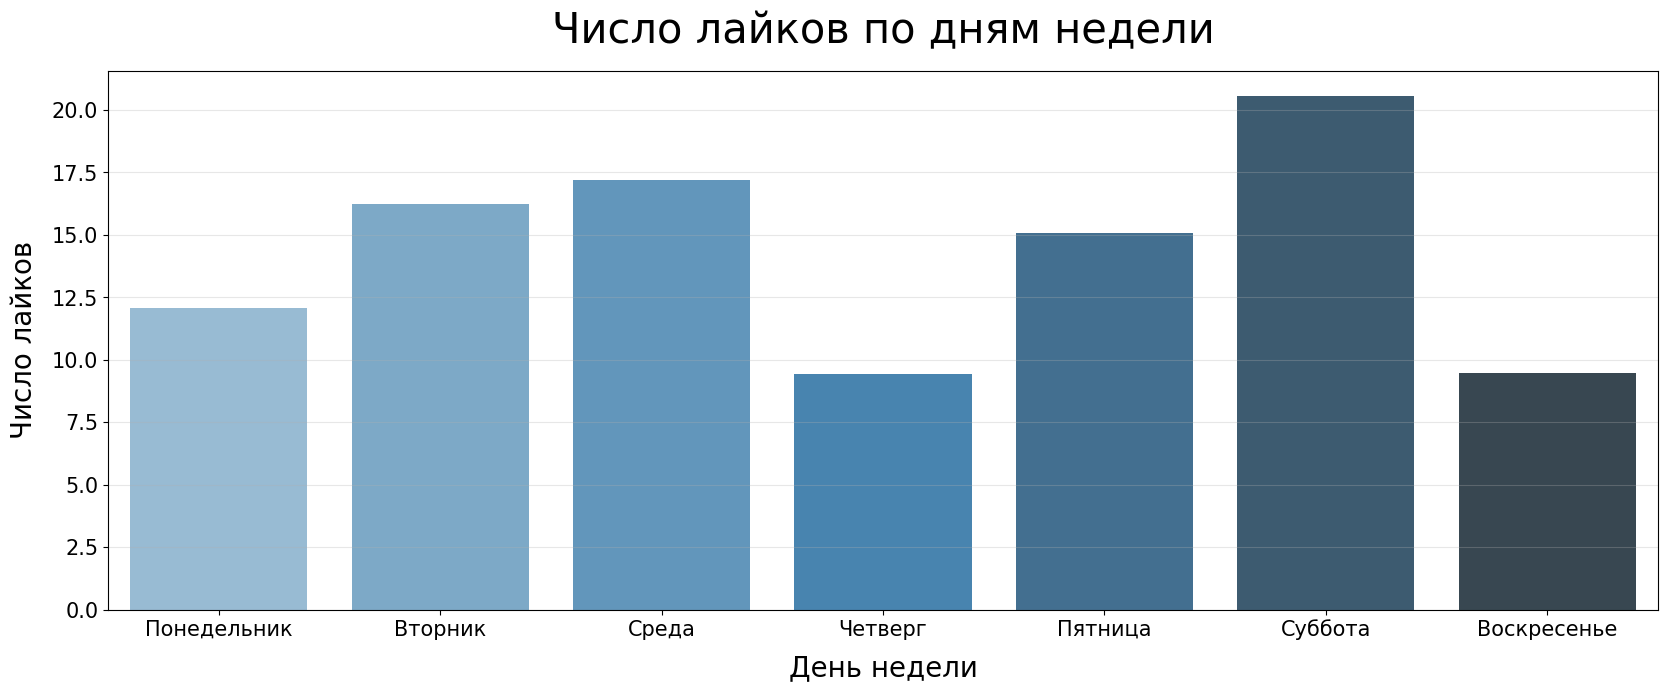

In [43]:
fig, ax = plt.subplots(figsize=(20, 7))

palette = ['#8da0cb', '#a6d854', '#ffd92f', '#e5c494',
           '#b3b3b3', '#fc8d62', '#e78ac3']

sns.barplot(x='day_name', y='procent', data=likes_day_number, ax=ax, palette='Blues_d')

plt.grid(axis='y', alpha=0.3)
plt.xlabel('День недели', labelpad=10, fontsize=20)
plt.ylabel('Число лайков', labelpad=10, fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Число лайков по дням недели', pad=20, fontsize=30);

**Вывод**: замечено влияние дня недели на число лайков. В течение рабочей недели лайки распределенны не равномерно. Условно можно выделить следующие категории:

- Будние дни: `вторник`, `среда` и `пятница` — с активностью на уровне *15-17%*
- Будние дни: `понедельник` и `четверг` — просадка по сравнению с остальными будними днями — активность на уровне *12%* в `понедельник` и особенно низкий показатель 9% в `четверг`
- Выходные дни: ярко выделяется `суббота` с наибольшим процентом активности — *19%*, а также контрастирует `воскресенье` с сопоставимой активностью с четвергом — около *9%*

### Влияние времени суток публикации на количество лайков

Формируем третий SQL запрос.

In [44]:
query3 = """
WITH
    w_l AS (WITH 
                i_n AS (WITH
                            i_l AS (SELECT *,
                                           LEAD(date) OVER(ORDER BY date_time) AS next_date, -- создаем поле со временем следующей публикации
                                           next_date - date AS interval -- считаем разницу между временем публикации настоящго поста и следующего
                                    FROM posts
                                    LIMIT 98 OFFSET 1) -- убираем записи, которые не имеют для себя пары 
                            SELECT *,
                                   NTILE(3) OVER (ORDER BY interval) AS int_id, -- разбиваем весь набор данных на диапазоны по интервалам между постами
                            FROM i_l)                                          -- ровно треть данных будет в 1 категории, 2 - во второй и 3 - в третьей
                        SELECT int_id,
                               COUNT(date) AS posts_count, -- считаем количество наблюдений в каждой категории
                               SUM(likes) AS likes, -- считаем сумму для каждой категории
                               SUM(likes) / COUNT(date) AS weighted_likes, -- считаем взвешенное число лайков в каждой категории
                               AVG(interval) AS int_avg -- рассчитываем среднее значение длительности интервала в каждой категории
                        FROM i_n                        -- чтобы присвоить имя категории исходя из её средней длительности
                        GROUP BY int_id)
SELECT (CASE int_id
           WHEN 1 THEN 'до минуты'
           WHEN 2 THEN 'пятнадцать минут'
           WHEN 3 THEN 'шесть часов'
       END) AS interval_type,
       ROUND(((weighted_likes / SUM(weighted_likes) OVER()) * 100), 2) AS procent -- считаем процент взвешенного число лайков от общей взвешенной суммы
FROM w_l
"""

likes_time_intrval = con.execute(query3).fetchdf()
likes_time_intrval

,interval_type,procent
0,пятнадцать минут,40.30
1,до минуты,31.07
2,шесть часов,28.62


#### Визуализируем распределение зависимости числа лайков от времени между постами

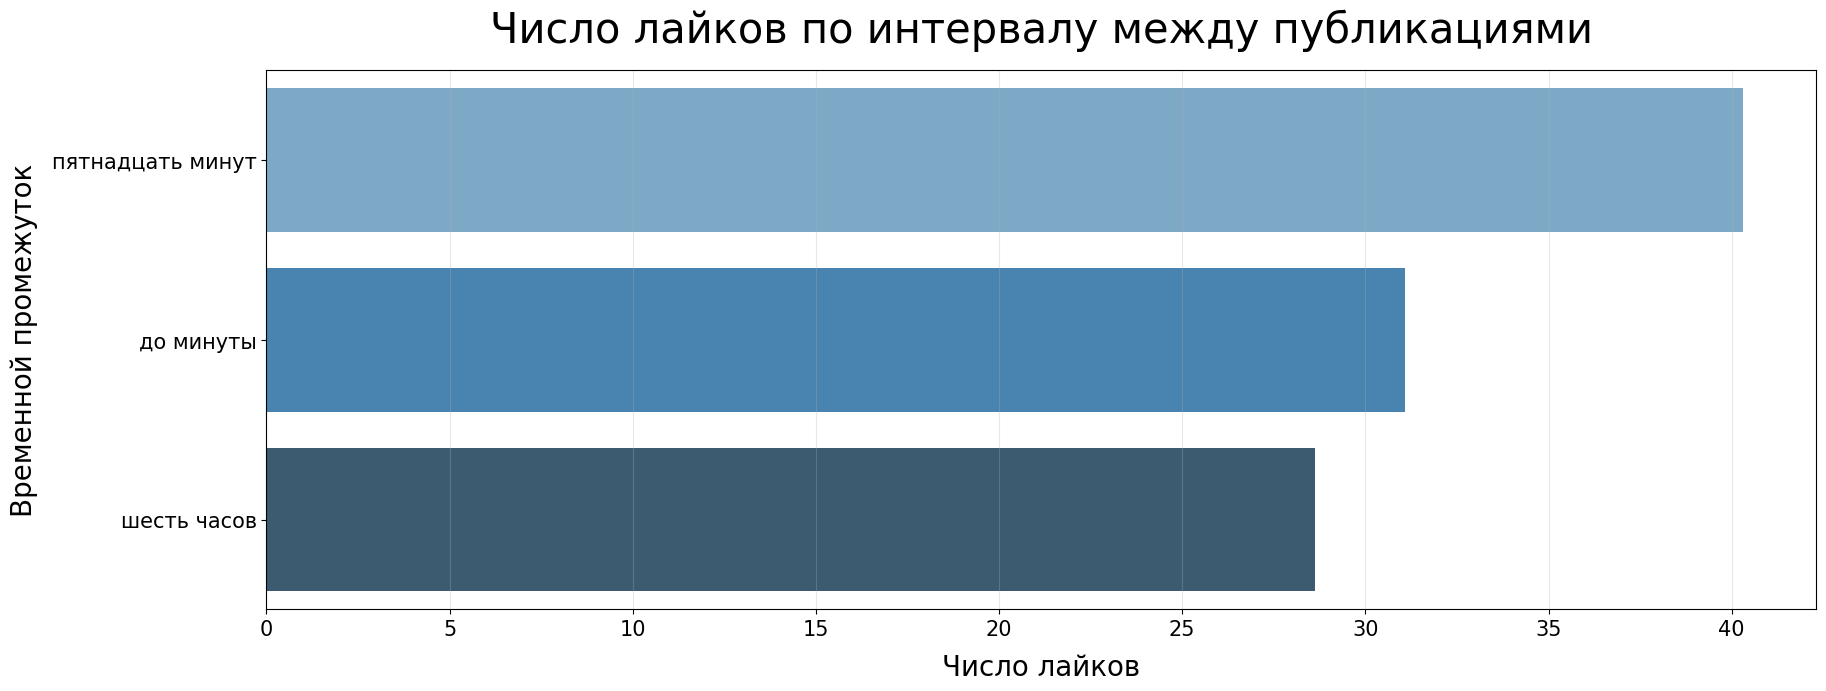

In [45]:
fig, ax = plt.subplots(figsize=(20, 7))

sns.barplot(x='procent', y='interval_type', data=likes_time_intrval, ax=ax, palette='Blues_d')

plt.grid(axis='x', alpha=0.3)
plt.xlabel('Число лайков', labelpad=10, fontsize=20)
plt.ylabel('Временной промежуток', labelpad=10, fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Число лайков по интервалу между публикациями', pad=20, fontsize=30);

**Вывод**: Обнаружена зависимость между количеством лайков и интервалом между публикациями:
- если следующая запись публикуется через 15 минут после первой, то первая получает до 40% лайков — это наиболее благоприятный интервал;
- если интервал между публикациями составляет менее минуты, это не влияет на популярность первой записи — она набирает в среднем 30% лайков;
- при интервале более шести часов активность также остаётся на уровне 30% лайков.

## Общий вывод:

**Замечено комплексное влияние критериев на популярность записи:**

1. Время суток:  
- хуже всего себя показало утро — разница с ближайшей категорией составляет 10 процентных пунктов, а с максимальной — почти в два раза больше: 14 процентных пунктов  
- лучше всего — вечер — с ближайшими днем и ночью разница около 5 процентных пунктов, а с минимальной — утром — почти 14 процентных пунктов

2. День недели:  
- в среднем 12%, но сильно выделяются выходные и четверг: суббота — 20%, а воскресенье и четверг — 9%, что в два раза меньше активности в субботу 
- суббота отличается от ближайших будних дней (в среднем 12%) на 5–8 процентных пунктов, а от минимальной категории — воскресенья — аж на 11 процентных пунктов

3. Интервал между публикациями:  
- пятнадцатиминутный интервал между публикациями с 40% лайков даёт прирост в 10 процентных пунктов по сравнению с другими категориями — очень быстрыми (до минуты) — 30% и очень долгими (несколько часов) — 30%.

---

Таким образом, во всех категориях критерии влияют на популярность записи примерно на ±10 процентных пунктов.

Лучше всего публиковать несколько записей с интервалом в 15 минут в субботу вечером.  
Хуже всего — несколько записей сразу или с большим перерывом в воскресенье или в четверг утром.
